In [1]:
import numpy as np 
import pandas as pd 
import tensorflow as tf
import torch

print("TensorFlow version:", tf.__version__)
print("PyTorch version:", torch.__version__)

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

TensorFlow version: 2.12.0
PyTorch version: 2.0.0
/kaggle/input/web-page-phishing-detection-dataset/dataset_phishing.csv


In [2]:
filename = '/kaggle/input/web-page-phishing-detection-dataset/dataset_phishing.csv'

df = pd.read_csv(filename)
df.head()

,url,length_url,length_hostname,ip,nb_dots,nb_hyphens,nb_at,nb_qm,nb_and,nb_or,...,domain_in_title,domain_with_copyright,whois_registered_domain,domain_registration_length,domain_age,web_traffic,dns_record,google_index,page_rank,status
0,http://www.crestonwood.com/router.php,37,19,0,3,0,0,0,0,0,...,0,1,0,45,-1,0,1,1,4,legitimate
1,http://shadetreetechnology.com/V4/validation/a...,77,23,1,1,0,0,0,0,0,...,1,0,0,77,5767,0,0,1,2,phishing
2,https://support-appleld.com.secureupdate.duila...,126,50,1,4,1,0,1,2,0,...,1,0,0,14,4004,5828815,0,1,0,phishing
3,http://rgipt.ac.in,18,11,0,2,0,0,0,0,0,...,1,0,0,62,-1,107721,0,0,3,legitimate
4,http://www.iracing.com/tracks/gateway-motorspo...,55,15,0,2,2,0,0,0,0,...,0,1,0,224,8175,8725,0,0,6,legitimate


In [3]:
df = df.drop('url', axis=1)

# Initializing the X and y values from the dataframe columns respectively
X = df.iloc[:, 0:87].values
y = df.iloc[:, 87].values

print('Dataframe columns taken as X input :\n------------------------------------\n',X)
print('\nDataframe column taken as y input :\n------------------------------------\n', y)

Dataframe columns taken as X input :
------------------------------------
 [[ 37.  19.   0. ...   1.   1.   4.]
 [ 77.  23.   1. ...   0.   1.   2.]
 [126.  50.   1. ...   0.   1.   0.]
 ...
 [105.  16.   1. ...   0.   1.  10.]
 [ 38.  30.   0. ...   0.   0.   4.]
 [477.  14.   1. ...   1.   1.   0.]]

Dataframe column taken as y input :
------------------------------------
 ['legitimate' 'phishing' 'phishing' ... 'legitimate' 'legitimate'
 'phishing']


In [4]:
# Encoding the y input values into 0s and 1s, respectively to phishing and legitimate
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
y = encoder.fit_transform(y)
print('Encoded y values :\n------------------\n', y)

Encoded y values :
------------------
 [0 1 1 ... 0 0 1]


In [5]:
# Splitting the dataset into training set and testing set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 0) 

In [6]:
# Feature scaling the X values of training and testing data
# Because we don't want one independent variable dominating the other, and it makes computations easy
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()

X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [7]:
# Defining function returning f1-score validation 
import keras.backend as K
def get_f1(y_true, y_pred): 
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [8]:
import tensorflow as tf
from keras import layers

# Define the generator model
def build_generator():
    model = tf.keras.Sequential()
    model.add(layers.Dense(256, input_shape=(87,)))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(512))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(1024))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Dense(256 * 256 * 3, activation='tanh'))
    model.add(layers.Reshape((256, 256, 3)))
    return model

# Define the discriminator model
def build_discriminator():
    model = tf.keras.Sequential()
    model.add(layers.Conv2D(64, (3, 3), strides=(2, 2), padding='same', input_shape=(256, 256, 3)))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Conv2D(128, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Conv2D(256, (3, 3), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU(alpha=0.2))
    model.add(layers.Flatten())
    model.add(layers.Dense(1, activation='sigmoid'))
    return model

# Define the combined generator and discriminator model
def build_pix2pix(generator, discriminator):
    model = tf.keras.Sequential()
    model.add(generator)
    discriminator.trainable = False
    model.add(discriminator)
    return model

# Create the generator, discriminator, and Pix2Pix models
generator = build_generator()
discriminator = build_discriminator()
pix2pix = build_pix2pix(generator, discriminator)

In [9]:
from tensorflow import metrics

# Compiling the Pix2Pix
pix2pix.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0002, beta_1=0.5), loss='binary_crossentropy', metrics = ['accuracy', metrics.Precision(), metrics.Recall(), get_f1])

In [10]:
# Fitting the Pix2Pix to the training set and validating with testing set
%time history = pix2pix.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=64, epochs=50)

Epoch 1/50
126/126 [==============================] - 22s 102ms/step - loss: 0.2160 - accuracy: 0.9209 - precision: 0.9237 - recall: 0.9165 - get_f1: 0.9173 - val_loss: 0.1523 - val_accuracy: 0.9428 - val_precision: 0.9298 - val_recall: 0.9597 - val_get_f1: 0.9425
Epoch 2/50
126/126 [==============================] - 13s 100ms/step - loss: 0.1326 - accuracy: 0.9510 - precision: 0.9521 - recall: 0.9492 - get_f1: 0.9424 - val_loss: 0.1399 - val_accuracy: 0.9481 - val_precision: 0.9551 - val_recall: 0.9419 - val_get_f1: 0.9469
Epoch 3/50
126/126 [==============================] - 12s 99ms/step - loss: 0.1111 - accuracy: 0.9590 - precision: 0.9590 - recall: 0.9585 - get_f1: 0.9589 - val_loss: 0.1377 - val_accuracy: 0.9507 - val_precision: 0.9465 - val_recall: 0.9569 - val_get_f1: 0.9503
Epoch 4/50
126/126 [==============================] - 12s 99ms/step - loss: 0.0949 - accuracy: 0.9625 - precision: 0.9616 - recall: 0.9630 - get_f1: 0.9539 - val_loss: 0.3588 - val_accuracy: 0.8895 - val_pr

In [11]:
# Evaluating the Pix2Pix model
%time loss, accuracy, precision, recall, f1 = pix2pix.evaluate(X_test, y_test, verbose=2)

108/108 - 2s - loss: 0.2661 - accuracy: 0.9627 - precision: 0.9686 - recall: 0.9574 - get_f1: 0.9591 - 2s/epoch - 17ms/step
CPU times: user 811 ms, sys: 36.5 ms, total: 848 ms
Wall time: 2.61 s


In [12]:
# Predicting the testing set results
y_pred = pix2pix.predict(X_test)
y_pred = (y_pred > 0.5)
print(y_pred)

108/108 [==============================] - 2s 13ms/step
[[False]
 [ True]
 [ True]
 ...
 [False]
 [ True]
 [False]]


In [13]:
# Determining the accuracy of the model 
from sklearn.metrics import accuracy_score 

accuracy = accuracy_score(y_test, y_pred)
print('Accuracy : ',accuracy)

Accuracy :  0.9626713327500729


In [14]:
# Making the confusion matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
print(cm)

[[1636   54]
 [  74 1665]]


Text(0.5, 23.52222222222222, 'Predicted label')

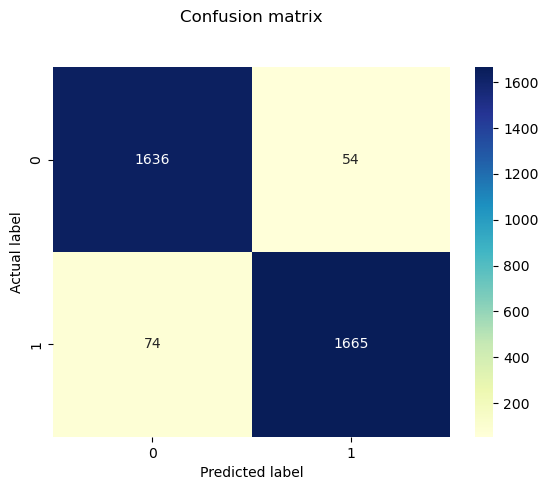

In [15]:
# Visualizing the confusion matrix
import seaborn as sns
import matplotlib.pyplot as plt

p = sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu" ,fmt='g')
plt.title('Confusion matrix', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')

In [16]:
# Making the classification report
from sklearn.metrics import classification_report

report = classification_report(y_test, y_pred, labels=[0, 1], zero_division=1)
print(report)

              precision    recall  f1-score   support

           0       0.96      0.97      0.96      1690
           1       0.97      0.96      0.96      1739

    accuracy                           0.96      3429
   macro avg       0.96      0.96      0.96      3429
weighted avg       0.96      0.96      0.96      3429



108/108 [==============================] - 1s 14ms/step


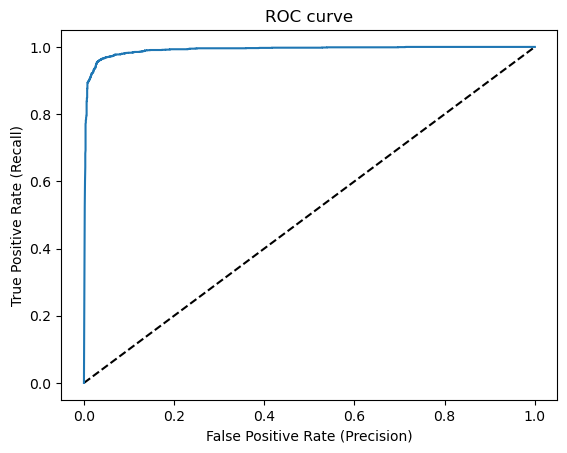

In [17]:
# Graphing the ROC curve
from sklearn.metrics import roc_curve
y_pred_proba = pix2pix.predict(X_test)

precision, recall, f1 = roc_curve(y_test, y_pred_proba)
plt.plot([0,1],[0,1],'k--')

plt.plot(precision, recall, label='Pix2Pix')
plt.xlabel('False Positive Rate (Precision)') #FPR, Precision - probability of a false alarm) 
plt.ylabel('True Positive Rate (Recall)') #TPR, also known as Recall)
plt.title('ROC curve')
plt.show()

In [18]:
# Determining the area under ROC curve
from sklearn.metrics import roc_auc_score
roc_auc_score(y_test,y_pred_proba)

0.991152161855926